In [105]:
import numpy as np
import datetime
import pandas as pd

import time
import pickle
import os
from pathlib import Path

from math import log10, floor

import matplotlib.pyplot as plt
import matplotlib



In [131]:
class CountriesByAge(object):
    def __init__(self):
        df = pd.read_csv("../DataByAge/world_population_by_age_UN.csv")
        self.df2020 = df[df["Reference date (as of 1 July)"] == 2020]
        
        
    def GetByCode(self,code):
        ages = self.df2020[self.df2020["Country code"] == code]
        
        age = {}
        for a in ["%d-%d"%(x,x+4) for x in range(0,96,5)]+["100+"]:
            age[a] = float(ages.iloc[0][a])*1000
        return age
        
cba = CountriesByAge()

class Country(object):
    def __init__(self,name,iso,code):
        self.name = name
        self.iso = iso
        self.code = code
        self.population = cba.GetByCode(self.code)
             
        # number of cases per day
        self.raw_data = {"cases":None,"deaths":None,"hospitalized":None,"ICU":None}
        self.data = {}
        self.weekly = {}
        
        # Different hooks along the pre-processing
        self.Load()
        self.Process()
        self.GenWeeklySeries()
        # Now contains a weekly dataseries
    
    def _splitAG(self,age_group):
        ages = []
        if "+" not in age_group:
            a,b = map(int,age_group.split("-"))
            for a in ["%d-%d"%(x,x+4) for x in range(a,b+1,5)]:
                ages.append(a)
        else:
            age = int(age_group.split("+")[0])
            ages = []
            for a in ["%d-%d"%(x,x+4) for x in range(age,96,5)]+["100+"]:
                ages.append(a)
        return ages
    
    def GetPopulation(self,age_group):
        total = np.sum(list(self.population.values()))
        ages = self._splitAG(age_group)
        n_ages,f_ages = {},{}
        for a in ages:
            p = self.population[a]
            n_ages[a] = p
            f_ages[a] = p/1.*total
        return n_ages,f_ages
            
        
        
    def Load(self):
        pass
    
    def Process(self):
        pass
    
    def GenWeeklySeries(self,data=None):
        if data == None:
            data = self.data
        for k,v in data.items():
            self.weekly[k] = v.resample('W',label='left').sum()
             
    def IsAvailable(self,key):
        return self.data.get(key,None) != None
                
class BasicCountry(Country):
    def __init__(self,name,iso,code):
        super(BasicCountry,self).__init__(name,iso,code)
        
    def Load(self):
        for k in self.raw_data.keys():
            fn_full = "../DataByAge/"+iso+"/"+k+".csv"
            try:
                df = pd.read_csv(fn_full,header=0,index_col=0)
                self.raw_data[k] = df
            except:
                pass
            
    def Process(self,data=None):
        if data == None:
            data = self.raw_data
            
        replace = {"80-":"80+","90-120":"90+"}
        unused = ["confirmed","deaths"]
        drop = ["Unknown","<50"]
        for k,v in data.items():
            if type(v) != type(None):
                columns = v.columns
            
                def replace_index(r):
                    if r in replace.keys():
                        r = replace[r]
                    return r
            
                columns = map(replace_index,columns)
                
                def remove_unused(r):
                    for u in unused:
                        if u in r:
                            r = r.replace(u,"").lstrip()
                    return r
                
                v.columns = map(remove_unused,columns)
                
                for d in drop:
                    if d in v.columns:
                        del v[d]
                
                # Convert the index to datetime
                v.index = pd.to_datetime(list(v.index))
                self.data[k] = v
                
class RemoveNamedDoubleIndex(BasicCountry):
    def __init__(self,name,iso,code):
        super(RemoveNamedDoubleIndex,self).__init__(name,iso,code)
        
    def Process(self):
        for k,v in self.raw_data.items():
            if type(v) != type(None):
                columns = v.columns
                
                def remove_double_index(r):
                    if "(" in r and ")" in r and "," in r:
                        r = r.split("'")[3]
                    return r
                        
                v.columns = map(remove_double_index,columns)
                
                def parse_datetime(s):
                    return datetime.datetime.strptime(s,'%d-%m-%Y')
                
                v.index = map(parse_datetime,v.index)
        super(RemoveNamedDoubleIndex,self).Process(self.raw_data)
    
class Switzerland(BasicCountry):
    def __init__(self,**kwargs):
        super(Switzerland,self).__init__("Switzerland","CHE",276)
        
    def Process(self):
        data = {}
        for k,v in self.raw_data.items():
            if type(v) != type(None):
                d = v.diff(axis=0)
                
                d = d.iloc[1:]
                data[k] = d
        super(Switzerland,self).Process(data)
        


In [132]:
class Germany(Country):
    def __init__(self,**kwargs):
        super(Germany,self).__init__("Germany","DE",276)
        
    def Load(self):
        pass
    
    def GenWeeklySeries(self,data=None):
        if data == None:
            print("Data is ignored for Germany")
        self.weekly = {}
        tindex = pd.date_range(start=datetime.datetime(2020,6,16),end=datetime.date(2020,10,6),freq="7D",closed='left')
        
        deaths = {}
        deaths_keys = ["0-9","10-19","20-29","30-39","40-49","50-59","60-69","70-79","80-89","90-99","100+"]
        deaths[41] = [   1,   1,  10,  27,  84, 358, 924,2149,4204,1731,  53] # Sitreport Di 06.10.2020

        deaths[40] = [   1,   1,  10,  26,  83, 348, 923,2136,4158,1718,  52] # Sitreport Di 30.09.2020
        deaths[39] = [   1,   1,  10,  26,  82, 347, 914,2120,4137,1702,  52] # Sitreport Di 22.09.2020
        deaths[38] = [   1,   1,  10,  25,  82, 344, 911,2110,4124,1698,  52] # Sitreport Di 15.09.2020
        deaths[37] = [   1,   1,  10,  25,  81, 340, 908,2099,4115,1693,  52] # Sitreport Di 08.09.2020
        deaths[36] = [   1,   1,  10,  24,  81, 336, 901,2090,4109,1692,  52] # Sitreport Di 01.09.2020

        deaths[35] = [   1,   1,  10,  23,  81, 332, 895,2087,4101,1689,  52] # Sitreport Di 25.08.2020
        deaths[34] = [   1,   1,  10,  23,  79, 330, 893,2080,4082,1682,  50] # Sitreport Di 18.08.2020
        deaths[33] = [   1,   2,  10,  23,  79, 329, 891,2071,4065,1676,  50] # Sitreport Di 11.08.2020
        deaths[32] = [   1,   2,   9,  23,  79, 327, 888,2060,4045,1667,  50] # Sitreport Di 04.08.2020

        deaths[31] = [   1,   2,   9,  23,  78, 326, 881,2052,4033,1662,  50] # Sitreport Di 28.07.2020
        deaths[30] = [   1,   2,   9,  23,  76, 322, 877,2049,4022,1654,  50] # Sitreport Di 21.07.2020
        deaths[29] = [   1,   2,   9,  23,  76, 322, 874,2044,4010,1652,  51] # Sitreport Di 14.07.2020
        deaths[28] = [   1,   2,   9,  23,  75, 319, 865,2033,4001,1640,  51] # Sitreport Di 07.07.2020

        deaths[27] = [   1,   2,  10,  23,  72, 317, 857,2019,3982,1634,  51] # Sitreport Di 30.06.2020
        deaths[26] = [   1,   2,   9,  23,  69, 312, 848,2003,3954,1618,  51] # Sitreport Di 23.06.2020
        deaths[25] = [   1,   2,   9,  23,  69, 307, 835,1980,3922,1597,  50] # Sitreport Di 16.06.2020

        
        
        deaths_by_age = {}
        dkws = [x for x in deaths.keys()]
        for i,dk in enumerate(deaths_keys):
            a = []
            for j,w in enumerate(range(min(dkws),max(dkws)+1)):
                a.append(deaths[w][i])
            deaths_by_age[dk] = np.diff(np.array(a))
            
        deaths_by_age["90+"] = deaths_by_age["90-99"]+deaths_by_age["100+"]
        del deaths_by_age["90-99"]
        del deaths_by_age["100+"]
        
        df = pd.DataFrame.from_dict(deaths_by_age)
        df.index = tindex
        self.weekly["deaths"] = df
        
        cases = {}
        # cases starting KW25 source sit-rep table, 1 week less than SurvStat
        cases["100+"] = np.array([1,0,0,0,2,0,1,5,2,1,1,1,1,6,3,3,0])
        cases["90-99"]= np.array([36,26,24,15,25,18,38,16,24,17,28,23,43,67,90,102,0])

        # Via survstat
        cases["0-9"] = np.array([159,135,141,145,140,161,150,190,273,284,224,233,227,291,301,312,22])+np.array([176,140,124,115,138,151,199,285,408,380,351,318,325,351,384,400,34])
        cases["10-19"] = np.array([192,145,104,100,150,191,250,364,544,575,478,431,497,514,572,662,34])+np.array([240,167,138,148,192,248,365,544,740,874,830,766,827,1024,1032,1261,112])
        cases["20-29"] = np.array([375,255,258,236,301,376,520,736,1163,1547,1327,1242,1276,1505,1572,1666,149])+np.array([393,323,315,226,307,410,508,606,833,1194,1213,1148,1233,1474,1429,1705,141])
        cases["30-39"] = np.array([402,331,260,259,295,381,424,510,697,940,853,933,930,1203,1291,1460,120])+np.array([374,299,226,202,251,360,382,513,643,759,711,647,690,897,993,1104,96])
        cases["40-49"] = np.array([447,271,214,189,253,321,428,484,636,714,654,642,682,834,851,1001,96])+np.array([375,277,222,181,233,335,385,451,571,689,605,607,690,871,885,1145,115])
        cases["50-59"] = np.array([315,263,185,172,207,291,350,416,471,558,536,549,667,891,989,1157,106])+np.array([184,202,156,116,175,242,285,307,324,428,350,387,551,753,854,1062,100])
        cases["60-69"] = np.array([120,108,110,93,109,153,150,202,192,238,244,246,337,491,526,646,79])+np.array([69,65,62,62,70,85,85,120,110,119,130,127,224,291,299,423,24])
        cases["70-79"] = np.array([57,40,38,56,60,62,90,92,79,96,91,108,151,258,267,327,33])+np.array([65,57,40,40,42,57,71,55,71,66,67,75,145,180,229,282,21])
        cases["80+"] = np.array([144,111,100,72,91,103,168,140,163,105,110,109,257,371,419,558,49])
        
        
        # build 90+, 80-89
        cases["90+"] = cases["90-99"]+cases["100+"]
        cases["80-89"] = cases["80+"]-cases["90+"]
        
        del cases["80+"]
        del cases["90-99"]
        del cases["100+"]
        
        for k,v in cases.items():
            cases[k] = v[:-1]
        tindex = pd.date_range(start=datetime.datetime(2020,6,16),end=datetime.date(2020,10,6),freq="7D",closed='left')
        df = pd.DataFrame.from_dict(cases)
        df.index = tindex
        self.weekly["cases"] = df


In [133]:
cntrs = {}
cntrs["CZ"] = {"name":"Czech Republic","class":RemoveNamedDoubleIndex,"code":203}
cntrs["NL"] = {"name":"Netherlands","class":RemoveNamedDoubleIndex,"code":528}
cntrs["PRT"] = {"name":"Portugal","class":RemoveNamedDoubleIndex,"code":620}
cntrs["BE"] = {"name":"Belgium","class":RemoveNamedDoubleIndex,"code":56}

cntrs["DE"] = {"class":Germany,}
cntrs["CHE"] = {"class":Switzerland}

countries = {}
for iso,cntry in cntrs.items():
    countries[iso] = cntry["class"](name=cntry.get("name",None),iso=iso,code=cntry.get("code",None))


print(countries)

Data is ignored for Germany
{'CZ': <__main__.RemoveNamedDoubleIndex object at 0x1210e5390>, 'NL': <__main__.RemoveNamedDoubleIndex object at 0x1212f0dd0>, 'PRT': <__main__.RemoveNamedDoubleIndex object at 0x1264ce5d0>, 'BE': <__main__.RemoveNamedDoubleIndex object at 0x1212f0a50>, 'DE': <__main__.Germany object at 0x121106390>, 'CHE': <__main__.Switzerland object at 0x1210ff3d0>}


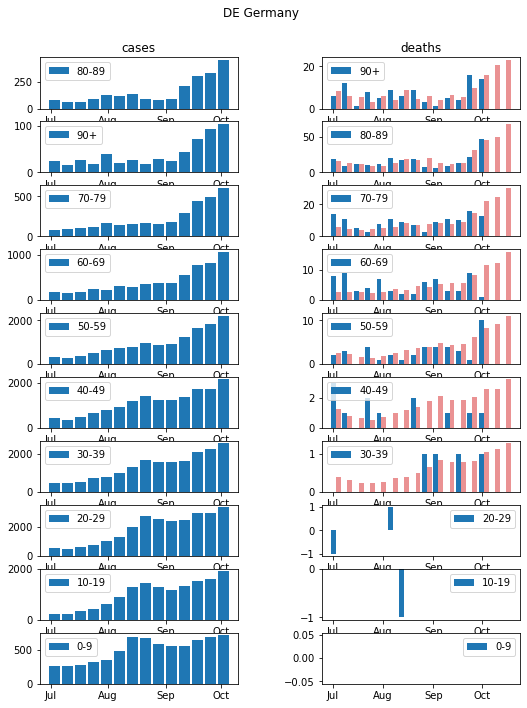

In [135]:
def ifr(s):
    return {"90+":.22,"80-89":.15,"80+":.17,"70-79":.05,"60-69":.015,"50-59":.005,"40-49":.0015,"30-39":.0005}.get(s,0.)

def ShowWeeklyOverview(country,start=datetime.datetime(2020,6,15)):
    
    data = country.weekly
    fig = plt.figure(figsize=(7.5,10))
    fig.subplots_adjust(wspace=0.425,hspace=0.25,left=0.09,right=0.98,top=0.91,bottom=0.04)
    
    possible_keys = ["cases","hospitalized","ICU","deaths"]
    keys = [x for x in possible_keys if x in data.keys()]
    n_ags = [len(data[x].columns) for x in keys]
    
    gs = fig.add_gridspec(max(n_ags), len(keys))
    
    
    
    splts = {}
    for i,k in enumerate(keys):
        splts[k] = {}
        for j,c in enumerate(data[k].columns[::-1]):
            ax = fig.add_subplot(gs[j,i])
            splts[k][c] = ax
            if j == 0:
                ax.set_title(k)
            # Formating
            ax.xaxis.set_major_locator( matplotlib.dates.MonthLocator() )
            ax.xaxis.set_major_formatter( matplotlib.dates.DateFormatter('%b') )
    
    for i,k in enumerate(keys):
        for j,c in enumerate(data[k].columns):
            ds = data[k][c]
            ds = ds[start:]
            
            ax = splts[k][c]
            ax.bar(ds.index[2:],ds[2:],label=c,width={"deaths":3}.get(k,6),align="edge")
            if k == "cases":
                dx = splts["deaths"].get(c,None)
                if dx != None:
                    dx.bar(ds.index+datetime.timedelta(days=3+14),ds*ifr(c),width=3,align="edge",alpha=.5,color="tab:red")
                    
            ax.legend()
            
#            ax.set_xticks(xticks)
            
            
            
    
    fig.suptitle(country.iso+" "+country.name)
    fig.savefig("plots/"+country.iso+".pdf")

#for k,v in countries.items():
 #   ShowWeeklyOverview(v)
#ShowWeeklyOverview(countries["CHE"])
ShowWeeklyOverview(countries["DE"])

In [110]:
def ShowWeeklyOverview(country,start=datetime.datetime(2020,6,15)):
    
    data = country.weekly
    fig = plt.figure(figsize=(7.5,10))
    fig.subplots_adjust(wspace=0.425,hspace=0.25,left=0.09,right=0.98,top=0.91,bottom=0.04)
    
    possible_keys = ["cases","hospitalized","ICU","deaths"]
    keys = [x for x in possible_keys if x in data.keys()]

In [95]:
print(countries["DE"].GetPopulation("80+"))
print(countries["DE"].GetPopulation("60+"))
print(countries["DE"].GetPopulation("5-34"))

({'80-84': 3259094.0, '85-89': 1635049.0, '90-94': 758147.0, '95-99': 204159.0, '100+': 19295.0}, {'80-84': 273059752445830.0, '85-89': 136990855488305.0, '90-94': 63520546549915.0, '95-99': 17105246427255.0, '100+': 1616611218775.0})
({'60-64': 5820703.0, '65-69': 4823439.0, '70-74': 3833823.0, '75-79': 3637591.0, '80-84': 3259094.0, '85-89': 1635049.0, '90-94': 758147.0, '95-99': 204159.0, '100+': 19295.0}, {'60-64': 487681460013335.0, '65-69': 404126747886855.0, '70-74': 321212815371735.0, '75-79': 304771724276495.0, '80-84': 273059752445830.0, '85-89': 136990855488305.0, '90-94': 63520546549915.0, '95-99': 17105246427255.0, '100+': 1616611218775.0})
({'5-9': 3822225.0, '10-14': 3811645.0, '15-19': 4118970.9999999995, '20-24': 4553436.0, '25-29': 4823925.0, '30-34': 5441865.0}, {'5-9': 320241089177625.0, '10-14': 319354655039525.0, '15-19': 345103639720594.94, '20-24': 381504831385020.0, '25-29': 404167466884125.0, '30-34': 455940917857425.0})
